In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score

In [4]:
SALARY_PATH = '/content/gdrive/MyDrive/dsc-148/salaries_1985to2018.csv'
STATS_PATH = '/content/gdrive/MyDrive/dsc-148/Player Totals.csv'
PLAYERS_PATH = '/content/gdrive/MyDrive/dsc-148/players.csv'
CPI_PATH = '/content/gdrive/MyDrive/dsc-148/cpi.xlsx'

salaries = pd.read_csv(SALARY_PATH)
stats = pd.read_csv(STATS_PATH)
players = pd.read_csv(PLAYERS_PATH)

In [5]:
stats.shape

(31814, 35)

In [6]:
cpi = pd.read_excel(CPI_PATH).set_index('Year')
cpi.loc[2016] = {'Avg_CPI': 240.0, 'Chg_CPI': 0.013}
cpi.loc[2017] = {'Avg_CPI': 245.1, 'Chg_CPI': 0.021}

In [7]:
stats = stats.drop(columns=['seas_id', 'birth_year'])

In [8]:
stats[(stats.player =='A.C. Green') & (stats.season == 1997)][['player', 'season' , 'tm']].set_index(['player', 'season']).reset_index()

,player,season,tm
0,A.C. Green,1997,TOT
1,A.C. Green,1997,PHO
2,A.C. Green,1997,DAL


In [9]:
salaries.head()

,league,player_id,salary,season,season_end,season_start,team
0,NBA,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers
1,NBA,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers
2,NBA,abdelal01,500000,1992-93,1993,1992,Boston Celtics
3,NBA,abdelal01,805000,1993-94,1994,1993,Boston Celtics
4,NBA,abdelal01,650000,1994-95,1995,1994,Sacramento Kings


In [10]:
players.head()

,_id,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,...,draft_pick,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight
0,abdelal01,"June 24, 1968","Cairo, Egypt",0.3,50.2,0.0,70.1,256,13.0,5.7,...,25th overall,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb
1,abdulza01,"April 7, 1946","Brooklyn, New York",1.2,42.8,NaN,72.8,505,15.1,9.0,...,5th overall,1st round,Cincinnati Royals,1968,6-9,"John Jay in Brooklyn, New York",Zaid Abdul-Aziz,Power Forward and Center,Right,235lb
2,abdulka01,"April 16, 1947","New York, New York",3.6,55.9,5.6,72.1,1560,24.6,24.6,...,1st overall,1st round,Milwaukee Bucks,1969,7-2,"Power Memorial in New York, New York",Kareem Abdul-Jabbar,Center,Right,225lb
3,abdulma02,"March 9, 1969","Gulfport, Mississippi",3.5,44.2,35.4,90.5,586,15.4,14.6,...,3rd overall,1st round,Denver Nuggets,1990,6-1,"Gulfport in Gulfport, Mississippi",Mahmoud Abdul-Rauf,Point Guard,Right,162lb
4,abdulta01,"November 3, 1974","Maisons Alfort, France",1.1,41.7,23.7,70.3,236,11.4,7.8,...,11th overall,1st round,Sacramento Kings,1997,6-6,"Lycee Aristide Briand in Evreux, France",Tariq Abdul-Wahad,Shooting Guard,Right,223lb


In [11]:
players.columns

Index(['_id', 'birthDate', 'birthPlace', 'career_AST', 'career_FG%',
       'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS',
       'career_TRB', 'career_WS', 'career_eFG%', 'college', 'draft_pick',
       'draft_round', 'draft_team', 'draft_year', 'height', 'highSchool',
       'name', 'position', 'shoots', 'weight'],
      dtype='object')

In [12]:
relev_players = players[['name', 'draft_pick', 'draft_round', 'height', 'position', 'weight', '_id']]
players_salaries = salaries.merge(relev_players, right_on='_id', left_on='player_id').drop(columns='player_id')
players_salaries.shape

(14163, 13)

In [13]:
players_salaries.head()

,league,salary,season,season_end,season_start,team,name,draft_pick,draft_round,height,position,weight,_id
0,NBA,395000,1990-91,1991,1990,Portland Trail Blazers,Alaa Abdelnaby,25th overall,1st round,6-10,Power Forward,240lb,abdelal01
1,NBA,494000,1991-92,1992,1991,Portland Trail Blazers,Alaa Abdelnaby,25th overall,1st round,6-10,Power Forward,240lb,abdelal01
2,NBA,500000,1992-93,1993,1992,Boston Celtics,Alaa Abdelnaby,25th overall,1st round,6-10,Power Forward,240lb,abdelal01
3,NBA,805000,1993-94,1994,1993,Boston Celtics,Alaa Abdelnaby,25th overall,1st round,6-10,Power Forward,240lb,abdelal01
4,NBA,650000,1994-95,1995,1994,Sacramento Kings,Alaa Abdelnaby,25th overall,1st round,6-10,Power Forward,240lb,abdelal01


In [14]:
stats = stats.groupby(['player_id', 'season', 'player']).agg({'pos': 'min', 'age': 'min', 'experience': 'min', 'lg': 'min', 'g': 'sum', 'gs': 'sum', 'mp': 'sum', 'fg': 'sum', 'fga': 'sum', 'x3p': 'sum', 'x3pa': 'sum', 'x2p':'sum',
 'x2pa':'sum', 'ft': 'sum', 'fta': 'sum', 'orb': 'sum', 'drb': 'sum', 'trb': 'sum', 'ast': 'sum', 'stl': 'sum', 'blk': 'sum', 'tov':'sum', 'pf': 'sum', 'pts':'sum'}).reset_index()

stats['fg_percent'] = stats['fg'] / stats['fga']
stats['x3p_percent'] = stats['x3p'] / stats['x3pa']
stats['x2p_percent'] = stats['x2p'] / stats['x2pa']
stats['ft_percent'] = stats['ft'] / stats['fta']

stats = stats.drop(columns=['player_id'])

In [15]:
condition = (stats.g > 82)
stats.loc[condition, ['g', 'gs', 'mp', 'fg', 'fga', 'x3p', 'x3pa', 'x2p', 'x2pa', 'ft', 'fta', 'orb', 'drb','trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']] /= 2

In [16]:
final_salaries = players_salaries.merge(stats, left_on=['name', 'season_end'], right_on=['player', 'season'])
final_salaries.head()

,league,salary,season_x,season_end,season_start,team,name,draft_pick,draft_round,height,...,ast,stl,blk,tov,pf,pts,fg_percent,x3p_percent,x2p_percent,ft_percent
0,NBA,395000,1990-91,1991,1990,Portland Trail Blazers,Alaa Abdelnaby,25th overall,1st round,6-10,...,12.0,4.0,12.0,22.0,39.0,135.0,0.474138,NaN,0.474138,0.568182
1,NBA,494000,1991-92,1992,1991,Portland Trail Blazers,Alaa Abdelnaby,25th overall,1st round,6-10,...,30.0,25.0,16.0,66.0,132.0,432.0,0.493075,NaN,0.493075,0.752475
2,NBA,500000,1992-93,1993,1992,Boston Celtics,Alaa Abdelnaby,25th overall,1st round,6-10,...,27.0,25.0,26.0,97.0,189.0,578.0,0.517970,0.0,0.519068,0.758621
3,NBA,805000,1993-94,1994,1993,Boston Celtics,Alaa Abdelnaby,25th overall,1st round,6-10,...,3.0,2.0,3.0,17.0,20.0,64.0,0.436364,NaN,0.436364,0.640000
4,NBA,650000,1994-95,1995,1994,Sacramento Kings,Alaa Abdelnaby,25th overall,1st round,6-10,...,13.0,15.0,12.0,45.0,104.0,256.0,0.510823,0.0,0.515284,0.571429


In [17]:
final_salaries['height'] = final_salaries.height.apply(lambda s: int(s.split('-')[0]) * 12 + int(s.split('-')[1]))

In [18]:
final_salaries['adjusted_salary'] = final_salaries.apply(lambda row: (row.salary / cpi.loc[row.season_start].Avg_CPI) * 100, axis=1)
final_salaries.adjusted_salary

0        302218.821729
1        362701.908957
2        356379.187455
3        557093.425606
4        438596.491228
             ...      
12806    395833.333333
12807    312500.000000
12808    535541.003672
12809    431231.666667
12810    535541.003672
Name: adjusted_salary, Length: 12811, dtype: float64

In [19]:
final_salaries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12811 entries, 0 to 12810
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   league           12811 non-null  object 
 1   salary           12811 non-null  int64  
 2   season_x         12811 non-null  object 
 3   season_end       12811 non-null  int64  
 4   season_start     12811 non-null  int64  
 5   team             12811 non-null  object 
 6   name             12811 non-null  object 
 7   draft_pick       11123 non-null  object 
 8   draft_round      11123 non-null  object 
 9   height           12811 non-null  int64  
 10  position         12811 non-null  object 
 11  weight           12811 non-null  object 
 12  _id              12811 non-null  object 
 13  season_y         12811 non-null  int64  
 14  player           12811 non-null  object 
 15  pos              12811 non-null  object 
 16  age              12811 non-null  float64
 17  experience  

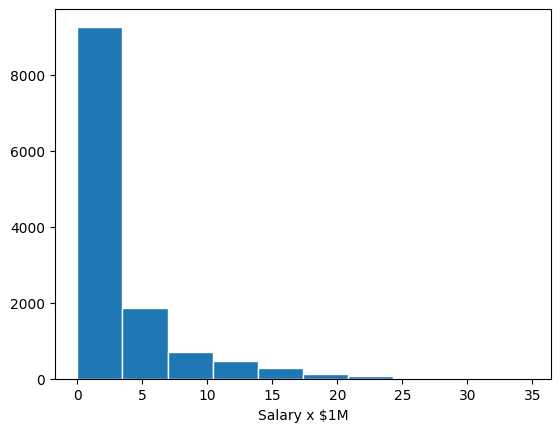

In [20]:
plt.hist(final_salaries.salary / 10**6, ec='w')
plt.xlabel('Salary x $1M')
plt.show()

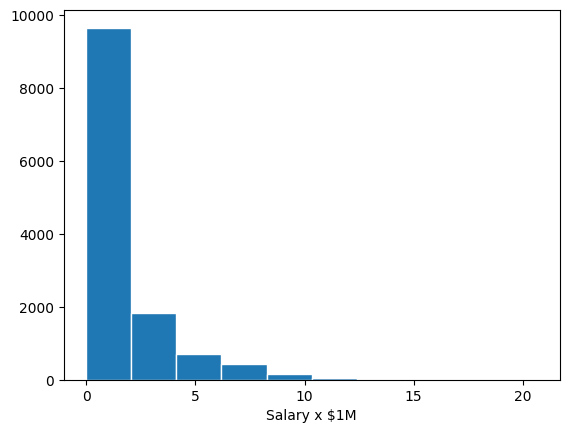

In [21]:
plt.hist(final_salaries.adjusted_salary / 10**6, ec='w')
plt.xlabel('Salary x $1M')
plt.show()

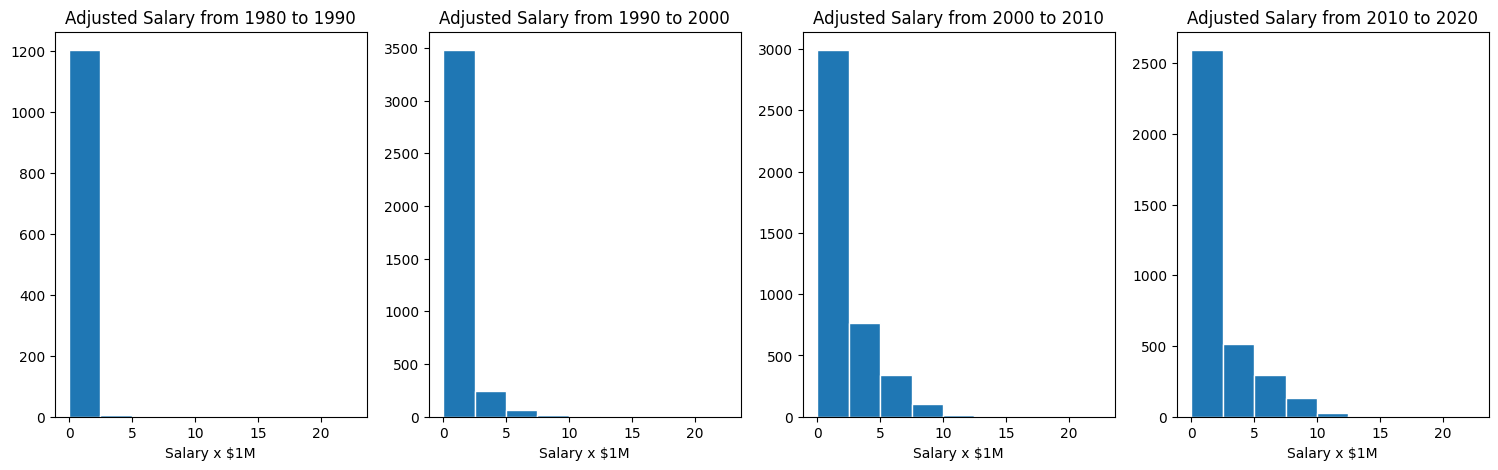

In [22]:
fig, axs = plt.subplots(1, 4)

fig.set_size_inches(18.5, 5)

for i, ax in enumerate(axs):
  ax.hist(final_salaries[(final_salaries.season_start >= 1980 + i * 10) & (final_salaries.season_start < 1990 + i * 10)].adjusted_salary / 10**6, ec='w', bins=np.arange(0, 25, 2.5))
  ax.set_title(f'Adjusted Salary from {1980 + i * 10} to {1990 + i * 10}')
  ax.set_xlabel('Salary x $1M')

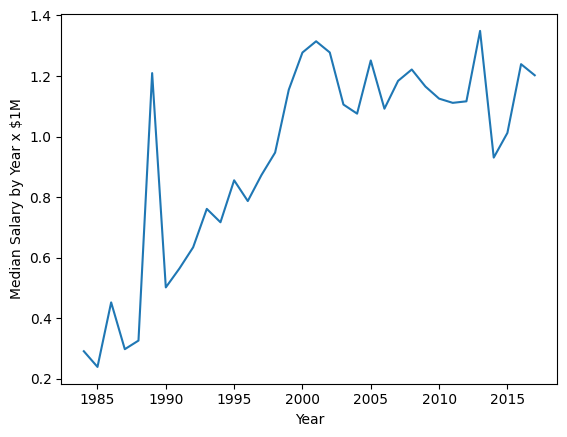

In [23]:
salary_by_year = final_salaries.groupby('season_start').adjusted_salary.median() / 10**6
plt.plot(salary_by_year)
plt.ylabel('Median Salary by Year x $1M')
plt.xlabel('Year')
plt.show()

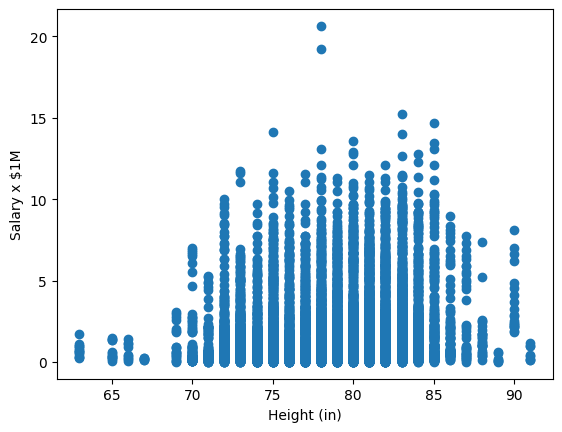

In [24]:
plt.scatter(final_salaries.height, final_salaries.adjusted_salary / 10**6)
plt.xlabel('Height (in)')
plt.ylabel('Salary x $1M')
plt.show()

In [25]:
cleaned_salaries = final_salaries.copy()
cleaned_salaries['draft_pick'] = final_salaries['draft_pick'].apply(lambda s: int(str(s).split(' ')[0][:-2]) if pd.notna(s) else 61)
cleaned_salaries['draft_pick'] = cleaned_salaries['draft_pick'].apply(lambda num: num if num <= 61 else 61)
cleaned_salaries['weight'] = cleaned_salaries['weight'].str.strip('lb').astype(int)
cleaned_salaries['x3p_percent'] = cleaned_salaries['x3p_percent'].fillna(0)
cleaned_salaries['x2p_percent'] = cleaned_salaries['x3p_percent'].fillna(0)
cleaned_salaries = cleaned_salaries.drop(cleaned_salaries[cleaned_salaries['fg_percent'].isna()].index)
cleaned_salaries = cleaned_salaries.drop(columns=['season_end', 'season_start', 'salary', 'league', 'draft_round', 'season_y', '_id', 'name', 'ft_percent', 'lg', 'position']).rename(columns={'season_x': 'season'})

In [26]:
cleaned_salaries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12782 entries, 0 to 12810
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           12782 non-null  object 
 1   team             12782 non-null  object 
 2   draft_pick       12782 non-null  int64  
 3   height           12782 non-null  int64  
 4   weight           12782 non-null  int64  
 5   player           12782 non-null  object 
 6   pos              12782 non-null  object 
 7   age              12782 non-null  float64
 8   experience       12782 non-null  int64  
 9   g                12782 non-null  float64
 10  gs               12782 non-null  float64
 11  mp               12782 non-null  float64
 12  fg               12782 non-null  float64
 13  fga              12782 non-null  float64
 14  x3p              12782 non-null  float64
 15  x3pa             12782 non-null  float64
 16  x2p              12782 non-null  float64
 17  x2pa        

In [27]:
cleaned_salaries['season'] = cleaned_salaries.season.apply(lambda s: int(s.split('-')[0]))

<ipython-input-28-ffc8401d6307>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  median_stats_by_year = final_salaries.groupby('season_start')['pts', 'ast', 'trb'].mean()


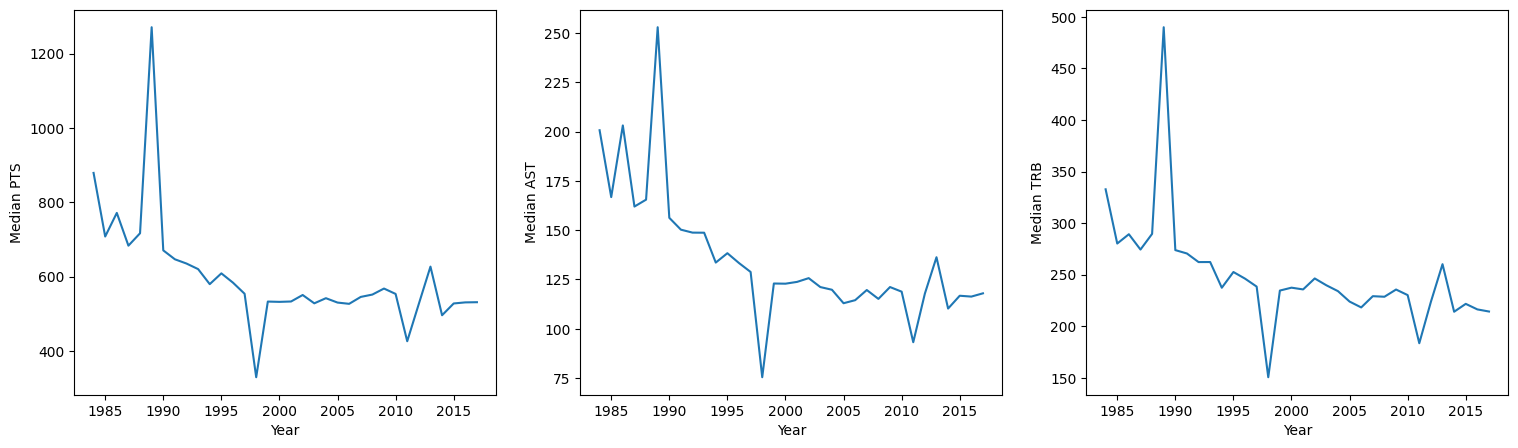

In [28]:
median_stats_by_year = final_salaries.groupby('season_start')['pts', 'ast', 'trb'].mean()

fig, axs = plt.subplots(1, 3)

fig.set_size_inches(18.5, 5)

for i, col in enumerate(median_stats_by_year):
  axs[i].plot(median_stats_by_year[col])
  axs[i].set_xlabel('Year')
  axs[i].set_ylabel(f'Median {col.upper()}')

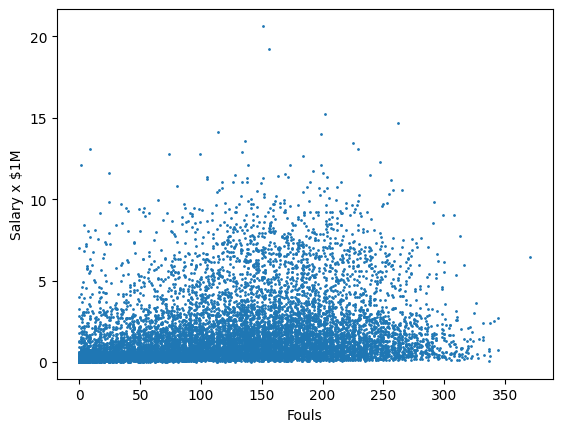

In [29]:
plt.scatter(cleaned_salaries.pf, cleaned_salaries.adjusted_salary / 10**6, s=1)
plt.xlabel('Fouls')
plt.ylabel('Salary x $1M')
plt.show()

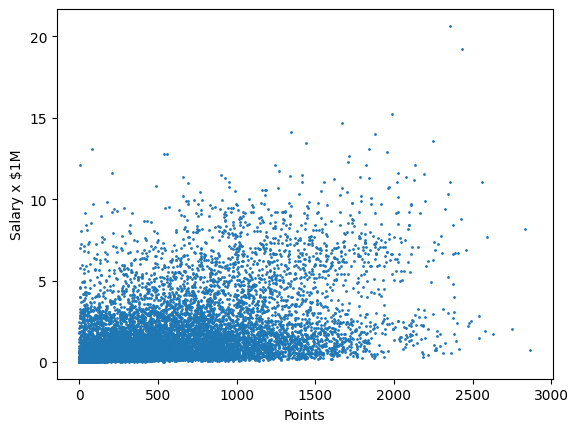

In [30]:
plt.scatter(cleaned_salaries.pts, cleaned_salaries.adjusted_salary / 10**6, s=1)
plt.xlabel('Points')
plt.ylabel('Salary x $1M')
plt.show()

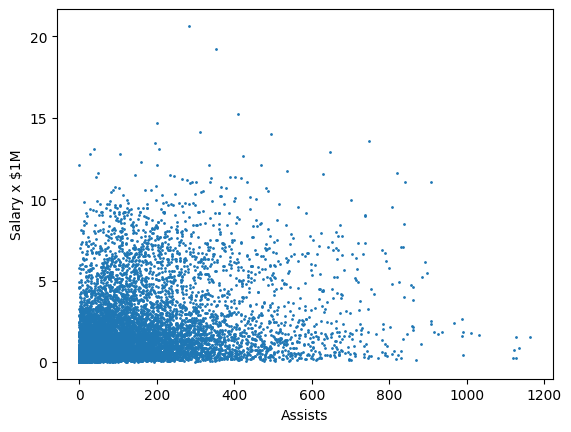

In [31]:
plt.scatter(cleaned_salaries.ast, cleaned_salaries.adjusted_salary / 10**6, s=1)
plt.xlabel('Assists')
plt.ylabel('Salary x $1M')
plt.show()

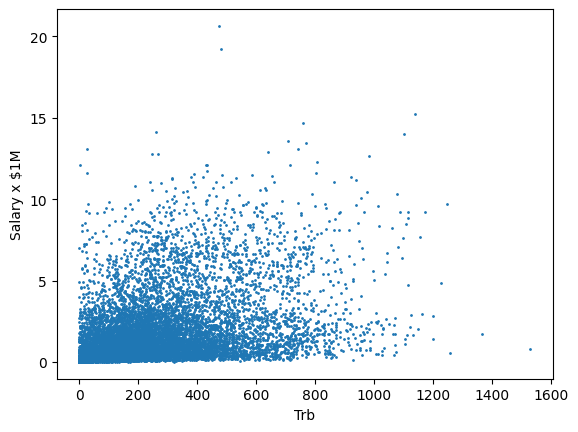

In [32]:
plt.scatter(cleaned_salaries.trb, cleaned_salaries.adjusted_salary / 10**6, s=1)
plt.xlabel('Trb')
plt.ylabel('Salary x $1M')
plt.show()

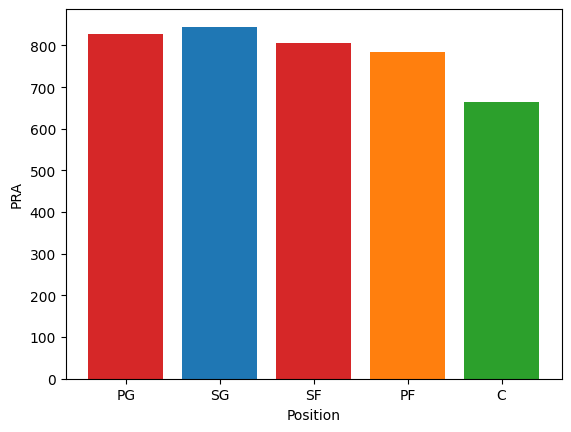

In [33]:
vis = cleaned_salaries.copy()
vis['pra'] = vis['pts'] + vis['ast'] + vis['trb']

by_pos = vis.groupby('pos').pra.median()[['PG', 'SG', 'SF', 'PF', 'C']]
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange', 'tab:green']
plt.bar(by_pos.index, by_pos, color=bar_colors)
plt.xlabel('Position')
plt.ylabel('PRA')
plt.show()

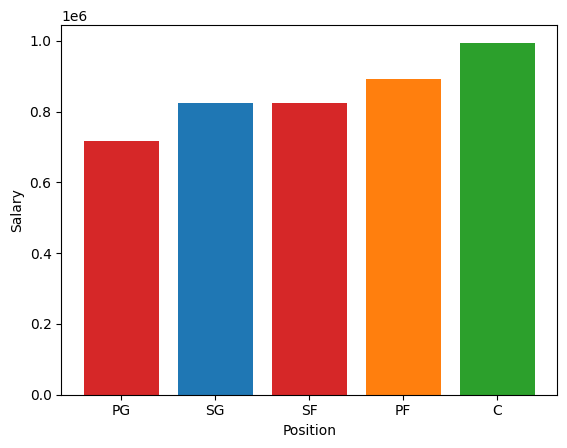

In [34]:
by_pos = vis.groupby('pos').adjusted_salary.median()[['PG', 'SG', 'SF', 'PF', 'C']]
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange', 'tab:green']
plt.bar(by_pos.index, by_pos, color=bar_colors)
plt.xlabel('Position')
plt.ylabel('Salary')
plt.show()

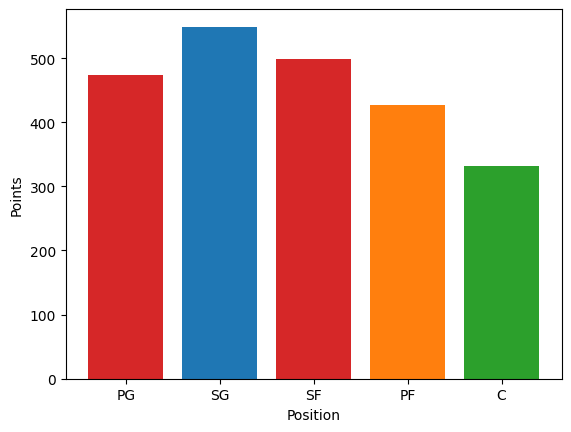

In [35]:
by_pos = vis.groupby('pos').pts.median()[['PG', 'SG', 'SF', 'PF', 'C']]
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange', 'tab:green']
plt.bar(by_pos.index, by_pos, color=bar_colors)
plt.xlabel('Position')
plt.ylabel('Points')
plt.show()

In [36]:
from sklearn.model_selection import train_test_split

baseline_df = cleaned_salaries.drop(columns = ['season', 'team', 'pos', 'player'])
X = baseline_df.drop(columns = ['adjusted_salary'])
y = baseline_df['adjusted_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
from sklearn.metrics import make_scorer

def rmse(actual, preds):
  return np.sqrt(((actual - preds)**2).mean())

mse_scorer = make_scorer(rmse,greater_is_better=False)

In [38]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
test_preds = linreg.predict(X_test)
train_preds = linreg.predict(X_train)

val_scores = cross_val_score(linreg, X_train, y_train, scoring=mse_scorer, cv=5)

print(f'train rmse: {rmse(y_train, train_preds) / 10**6}')
print(f'test rmse: {rmse(y_test, test_preds) / 10**6}')
print(f'cross validation rmse: {abs(val_scores.mean()) / 10**6}')

train rmse: 1.4507405071473831
test rmse: 1.4392344086241504
cross validation rmse: 1.454558938195042


In [39]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_train, y_train)
test_preds = dtr.predict(X_test)
train_preds = dtr.predict(X_train)

val_scores = cross_val_score(dtr, X_train, y_train, scoring=mse_scorer, cv=5)

print(f'train rmse: {rmse(y_train, train_preds) / 10**6}')
print(f'test rmse: {rmse(y_test, test_preds) / 10**6}')
print(f'cross validation rmse: {abs(val_scores.mean()) / 10**6}')

train rmse: 1.4368995195845535
test rmse: 1.5288360015032894
cross validation rmse: 1.4999940059774086


In [40]:
train_indices = X_train.index
test_indices = X_test.index

In [41]:
cleaned_salaries.loc[test_indices]

,season,team,draft_pick,height,weight,player,pos,age,experience,g,...,ast,stl,blk,tov,pf,pts,fg_percent,x3p_percent,x2p_percent,adjusted_salary
9273,1987,Seattle SuperSonics,8,83,220,Olden Polynice,C,23.0,1,82.0,...,33.0,32.0,26.0,81.0,215.0,337.0,0.464567,0.000000,0.000000,3.080986e+05
9641,1990,Miami Heat,4,79,215,Glen Rice,SF,23.0,2,77.0,...,189.0,101.0,26.0,166.0,216.0,1342.0,0.461023,0.385870,0.385870,1.185922e+06
7357,2014,Detroit Pistons,61,79,220,Cartier Martin,SF,30.0,7,23.0,...,11.0,3.0,1.0,5.0,20.0,36.0,0.283019,0.181818,0.181818,4.839505e+05
9555,2000,Charlotte Hornets,61,75,190,Eldridge Recasner,PG,33.0,7,43.0,...,39.0,6.0,1.0,27.0,30.0,103.0,0.333333,0.333333,0.333333,6.968641e+05
6394,1997,Chicago Bulls,50,75,175,Steve Kerr,PG,32.0,10,50.0,...,96.0,26.0,5.0,27.0,71.0,376.0,0.453642,0.438462,0.438462,4.672897e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662,2001,San Antonio Spurs,21,81,245,Mark Bryant,PF,36.0,14,30.0,...,10.0,7.0,2.0,6.0,38.0,56.0,0.454545,0.000000,0.000000,5.646527e+05
1028,2001,Sacramento Kings,2,73,190,Mike Bibby,PG,23.0,4,80.0,...,403.0,87.0,15.0,134.0,133.0,1098.0,0.452792,0.369565,0.369565,2.357365e+06
5034,2001,Washington Wizards,20,84,268,Brendan Haywood,C,22.0,1,62.0,...,29.0,21.0,91.0,50.0,158.0,315.0,0.493213,0.000000,0.000000,5.525692e+05
4545,1984,Utah Jazz,16,72,170,Rickey Green,PG,30.0,7,77.0,...,597.0,132.0,3.0,177.0,131.0,1000.0,0.477444,0.300000,0.300000,2.454283e+05


In [42]:
from lightgbm import LGBMRegressor

def train_lgb(cleaned_salaries):
  mdl_df = cleaned_salaries.copy()

  mdl_df = mdl_df.drop(columns = [col for col in cleaned_salaries.columns if 'percent' in col and col != 'e_fg_percent'] + ['team'])

  categorical_cols = ['pos']

  for col in categorical_cols:
    mdl_df[col] = mdl_df[col].astype('category')

  X_train = mdl_df.loc[train_indices].drop(columns=['adjusted_salary'])
  X_test = mdl_df.loc[test_indices].drop(columns=['adjusted_salary'])

  test_players = X_test.player
  X_train = X_train.drop(columns=['player'])
  X_test = X_test.drop(columns=['player'])

  lgb = LGBMRegressor()
  lgb.fit(X_train, y_train, categorical_feature = categorical_cols)

  train_preds = lgb.predict(X_train)
  test_preds = lgb.predict(X_test)

  val_scores = cross_val_score(lgb, X_train, y_train, scoring=mse_scorer, cv=5)

  return {'train rmse': rmse(y_train, train_preds) / 10**6,
          'test rmse': rmse(y_test, test_preds) / 10**6,
          'cross validation rmse': abs(val_scores.mean()) / 10**6}

In [43]:
out = train_lgb(cleaned_salaries)
print()
print(out)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4887
[LightGBM] [Info] Number of data points in the train set: 9586, number of used features: 27
[LightGBM] [Info] Start training from score 1620157.998070
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4860
[LightGBM] [Info] Number of data points in the train set: 7668, number of used features: 27
[LightGBM] [Info] Start training from score 1616035.137264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4858
[LightGBM] [Info] Number of data points in the

In [44]:
cleaned_salaries['ppg'] = cleaned_salaries['pts'] / cleaned_salaries['g']
cleaned_salaries['apg'] = cleaned_salaries['ast'] / cleaned_salaries['g']
cleaned_salaries['rpg'] = cleaned_salaries['trb'] / cleaned_salaries['g']
cleaned_salaries['mins_pg'] = cleaned_salaries['mp'] / cleaned_salaries['g']
cleaned_salaries['fga_pg'] = cleaned_salaries['fga'] / cleaned_salaries['g']
cleaned_salaries['fg_pg'] = cleaned_salaries['fg'] / cleaned_salaries['g']
cleaned_salaries['percent_games_started'] = cleaned_salaries['gs'] / cleaned_salaries['g']

In [45]:
out = train_lgb(cleaned_salaries)
print()
print(out)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6417
[LightGBM] [Info] Number of data points in the train set: 9586, number of used features: 33
[LightGBM] [Info] Start training from score 1620157.998070
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6390
[LightGBM] [Info] Number of data points in the train set: 7668, number of used features: 33
[LightGBM] [Info] Start training from score 1616035.137264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6388
[LightGBM] [Info] Number of data points in the train set: 7669, number of used features: 33
[LightGBM] [Info] 

In [46]:
statistical_cols = ['age', 'experience', 'g', 'gs', 'trb', 'ast', 'pts', 'fg', 'fga', 'mp']

for col in statistical_cols:
  cleaned_salaries[f'{col}_rank_by_season'] = cleaned_salaries.groupby('season')[col].rank(ascending=False)
  cleaned_salaries[f'{col}_rank_by_season_team'] = cleaned_salaries.groupby(['season', 'team'])[col].rank(ascending=False)
  cleaned_salaries[f'{col}_rank_by_season_pos'] = cleaned_salaries.groupby(['season', 'pos'])[col].rank(ascending=False)
  cleaned_salaries[f'{col}_rank_by_team_pos'] = cleaned_salaries.groupby(['season', 'team', 'pos'])[col].rank(ascending=False)

In [47]:
out = train_lgb(cleaned_salaries)
print()
print(out)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11407
[LightGBM] [Info] Number of data points in the train set: 9586, number of used features: 73
[LightGBM] [Info] Start training from score 1620157.998070
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11340
[LightGBM] [Info] Number of data points in the train set: 7668, number of used features: 73
[LightGBM] [Info] Start training from score 1616035.137264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11337
[LightGBM] [Info] Number of data points in the train set: 7669, number of used features: 73
[LightGBM] [Inf

In [48]:
mdl_df = cleaned_salaries.copy()

mdl_df = mdl_df.drop(columns = [col for col in cleaned_salaries.columns if 'percent' in col and col != 'e_fg_percent'] + ['team'])

categorical_cols = ['pos']

for col in categorical_cols:
  mdl_df[col] = mdl_df[col].astype('category')

X_train = mdl_df.loc[train_indices].drop(columns=['adjusted_salary'])
X_test = mdl_df.loc[test_indices].drop(columns=['adjusted_salary'])

test_players = X_test.player
X_train = X_train.drop(columns=['player'])
X_test = X_test.drop(columns=['player'])

lgb = LGBMRegressor(max_depth=7, num_leaves=50)
lgb.fit(X_train, y_train, categorical_feature = categorical_cols)

train_preds = lgb.predict(X_train)
test_preds = lgb.predict(X_test)

val_scores = cross_val_score(lgb, X_train, y_train, scoring=mse_scorer, cv=5)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11407
[LightGBM] [Info] Number of data points in the train set: 9586, number of used features: 73
[LightGBM] [Info] Start training from score 1620157.998070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [49]:
print(f'train rmse: {rmse(y_train, train_preds) / 10**6}')
print(f'test rmse: {rmse(y_test, test_preds) / 10**6}')
print(f'cross validation rmse: {abs(val_scores.mean()) / 10**6}')

train rmse: 0.6467210199905142
test rmse: 1.0374354047132268
cross validation rmse: 1.0144259524394692


In [50]:
from sklearn.model_selection import GridSearchCV

parameters = {'num_leaves': np.arange(40, 90, 10), 'max_depth': list(range(6, 11, 1)) + [-1]}
grid_search = GridSearchCV(lgb, parameters)
grid_search.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(estimator=LGBMRegressor(max_depth=7, num_leaves=50),
             param_grid={'max_depth': [6, 7, 8, 9, 10, -1],
                         'num_leaves': array([40, 50, 60, 70, 80])})

In [51]:
grid_search.best_params_

{'max_depth': 7, 'num_leaves': 50}

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

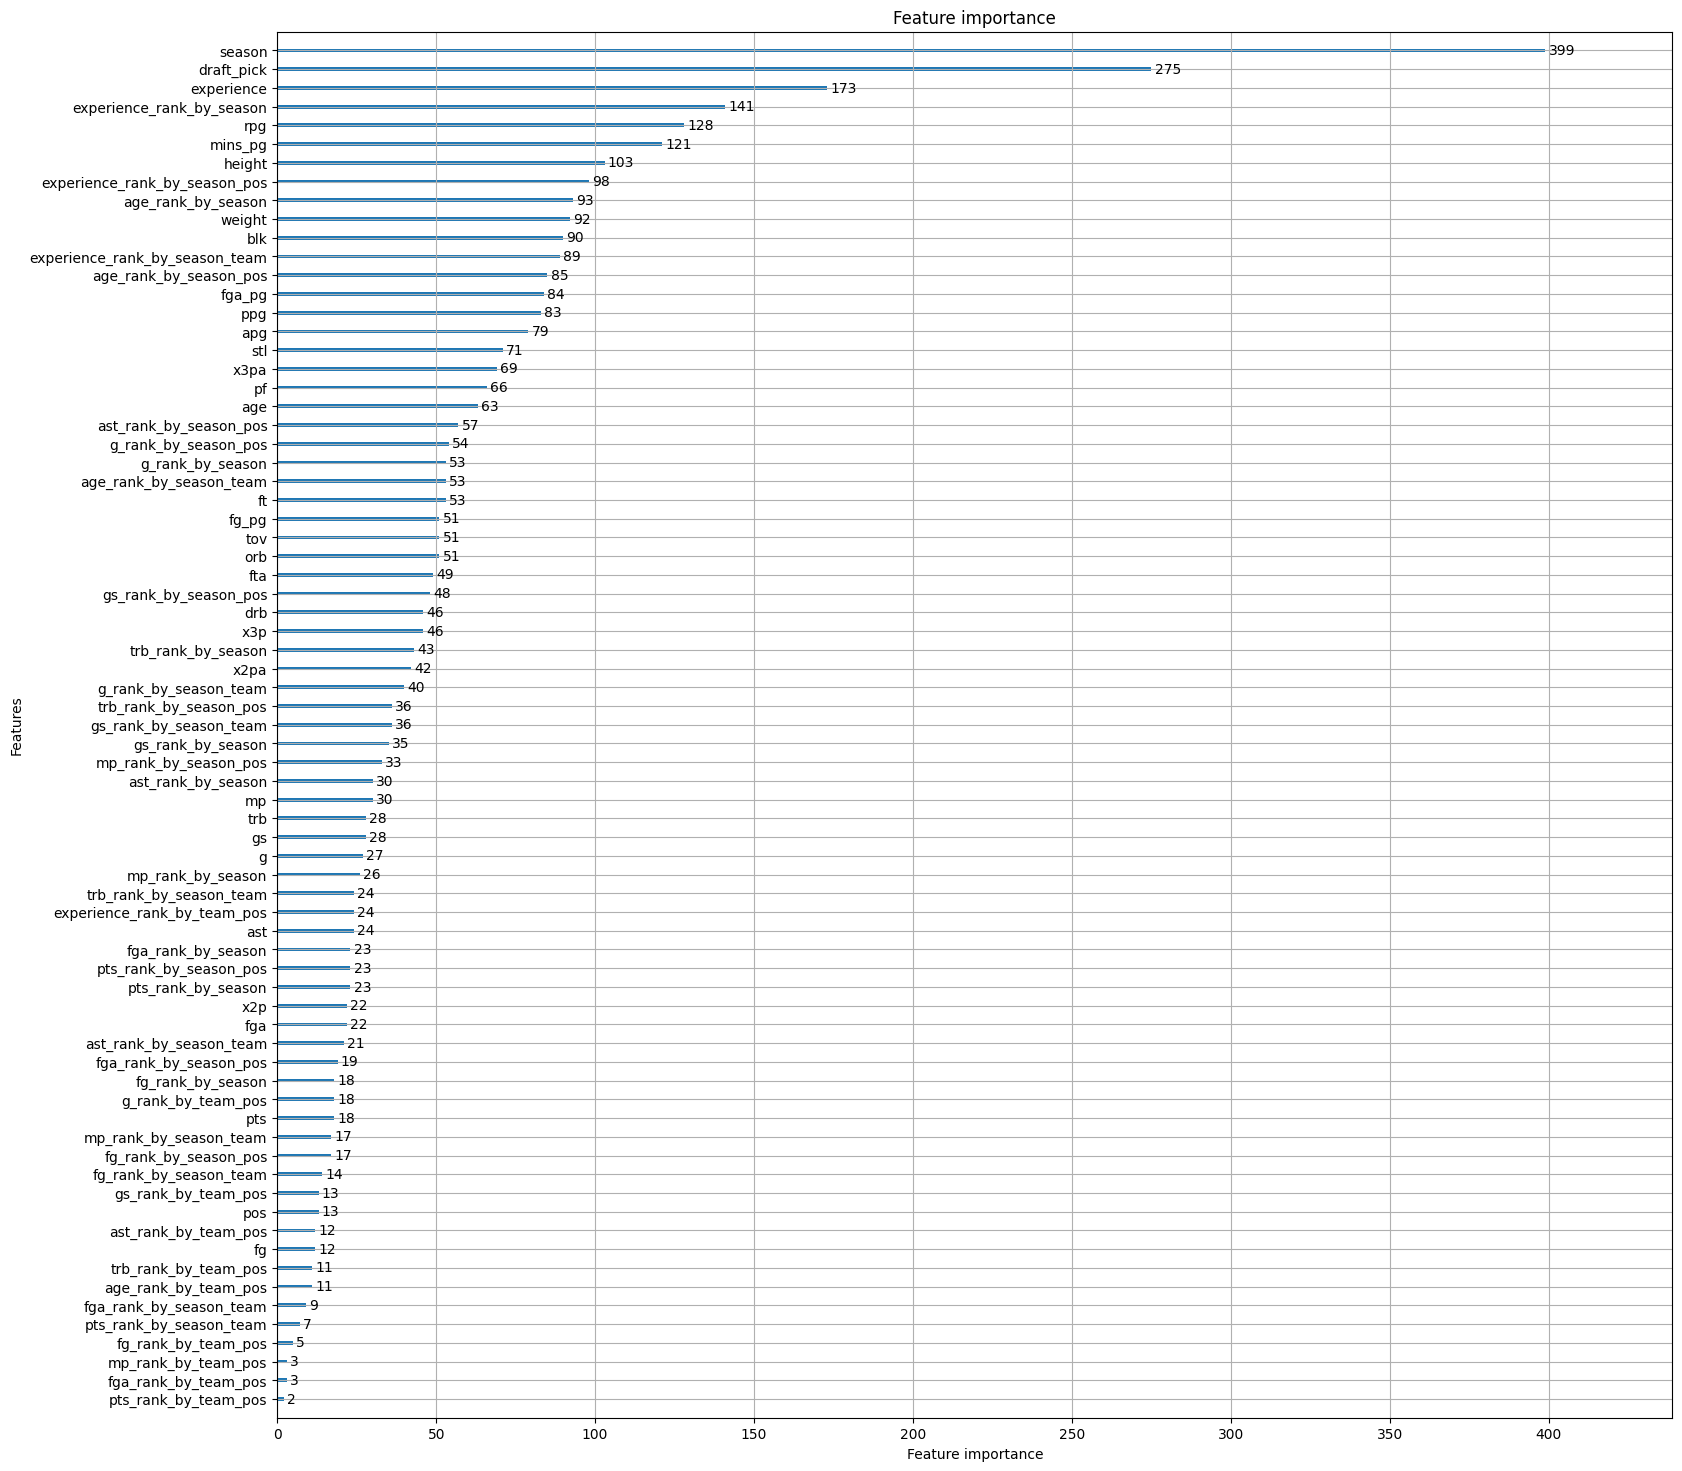

In [52]:
from lightgbm import plot_importance

plot_importance(lgb, figsize=(18, 18))

In [53]:
results = pd.DataFrame()
results['actual_salary'] = y_test / 10**6
results['predicted'] = test_preds / 10**6
results['error'] = np.abs(y_test - test_preds) / 10**6
results['relative_error'] = np.abs(results.predicted - results.actual_salary) / results.actual_salary
results['player'] = test_players
results['season'] = X_test.season
results['g'] = X_test.g

results.sort_values(by='error', ascending=False).head(15)

,actual_salary,predicted,error,relative_error,player,season,g
6301,20.647975,8.658663,11.989312,0.580653,Michael Jordan,1997,82.0
5029,12.128886,1.819921,10.308965,0.849952,Gordon Hayward,2017,1.0
11969,9.163604,1.464913,7.698691,0.840138,Chris Webber,2007,9.0
6055,0.174873,7.715764,7.540890,43.122043,Joe Johnson,2015,81.0
439,8.566459,1.066272,7.500187,0.875529,Gilbert Arenas,2011,17.0
8955,9.429622,2.594102,6.835520,0.724899,Chandler Parsons,2017,36.0
3624,1.342309,7.688014,6.345705,4.727454,Tyreke Evans,2017,52.0
7244,0.815217,6.816372,6.001155,7.361416,Karl Malone,2003,42.0
3753,8.160522,2.361009,5.799513,0.710679,Michael Finley,2005,77.0
5413,2.672283,8.430493,5.758210,2.154791,Juwan Howard,2003,81.0


In [54]:
low_salary_results = results[results.actual_salary < 1]
med_salary_results = results[(results.actual_salary > 1) & (results.actual_salary <= 3)]
high_salary_results = results[results.actual_salary > 3]

print(rmse(low_salary_results.actual_salary, low_salary_results.predicted))
print(rmse(med_salary_results.actual_salary, med_salary_results.predicted))
print(rmse(high_salary_results.actual_salary, high_salary_results.predicted))

0.5722343956587631
0.8814076670911676
2.0947737573930594


In [55]:
print(results.relative_error.median())
print(low_salary_results.relative_error.median())
print(med_salary_results.relative_error.median())
print(high_salary_results.relative_error.median())

0.3053475389033361
0.42620729633386345
0.2367653147704335
0.23004769206837183


In [56]:
x = np.sum((high_salary_results.actual_salary - high_salary_results.predicted)**2)
y = 1.0374354047132268 ** 2 * results.shape[0]

x / y, high_salary_results.shape[0] / results.shape[0]

(0.6199856213205955, 0.1520650813516896)

In [57]:
no_outliers_results = results.drop(results[((results.player == 'Michael Jordan') & (results.season == 1997)) | ((results.player == 'Gordon Hayward') & (results.season == 2017))].index)

print(f'test rmse (no outliers): {rmse(no_outliers_results.actual_salary, no_outliers_results.predicted)}')

test rmse (no outliers): 0.9993341003710401


Text(0, 0.5, 'absolute error * 1M')

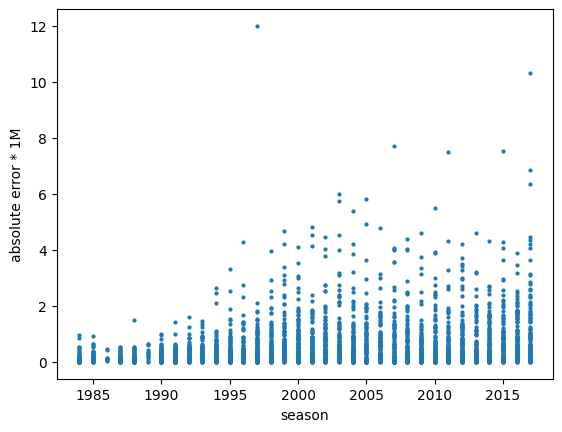

In [58]:
plt.scatter(results.season, results.error, s=4)
plt.xlabel('season')
plt.ylabel('absolute error * 1M')

In [59]:
X_train_filtered = mdl_df.loc[train_indices].drop(columns=['adjusted_salary'])

y_train_filtered = y_train.drop(X_train[X_train.g < 5].index)
X_train_filtered = X_train.drop(X_train[X_train.g < 5].index)

X_test_filtered = mdl_df.loc[test_indices].drop(columns=['adjusted_salary'])
y_test_filtered = y_test.drop(X_test[X_test.g < 5].index)

X_test['player'] = test_players
X_test_filtered = X_test.drop(X_test[X_test.g < 5].index)
X_test = X_test.drop(columns=['player'])

test_players = X_test_filtered.player
X_test_filtered = X_test_filtered.drop(columns=['player'])

lgb = LGBMRegressor(num_leaves=70, max_depth=7)
lgb.fit(X_train_filtered, y_train_filtered, categorical_feature = categorical_cols)

train_preds = lgb.predict(X_train_filtered)
test_preds = lgb.predict(X_test_filtered)

val_scores = cross_val_score(lgb, X_train_filtered, y_train_filtered, scoring=mse_scorer, cv=4)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11346
[LightGBM] [Info] Number of data points in the train set: 9356, number of used features: 73
[LightGBM] [Info] Start training from score 1643844.739994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [60]:
print(f'train rmse: {rmse(y_train_filtered, train_preds) / 10**6}')
print(f'test rmse: {rmse(y_test_filtered, test_preds) / 10**6}')
print(f'cross validation rmse: {abs(val_scores.mean()) / 10**6}')

train rmse: 0.6412769472036579
test rmse: 1.0269119821439807
cross validation rmse: 1.0245184521759947


In [61]:
from sklearn.model_selection import GridSearchCV

parameters = {'num_leaves': np.arange(40, 90, 10), 'max_depth': list(range(6, 11, 1)) + [-1]}
grid_search = GridSearchCV(lgb, parameters)
grid_search.fit(X_train_filtered, y_train_filtered)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(estimator=LGBMRegressor(max_depth=7, num_leaves=70),
             param_grid={'max_depth': [6, 7, 8, 9, 10, -1],
                         'num_leaves': array([40, 50, 60, 70, 80])})

In [62]:
grid_search.best_params_

{'max_depth': 7, 'num_leaves': 70}

In [63]:
results = pd.DataFrame()
results['actual_salary'] = y_test_filtered / 10**6
results['predicted'] = test_preds / 10**6
results['error'] = np.abs(y_test_filtered - test_preds) / 10**6
results['player'] = test_players
results['season'] = X_test_filtered.season
results['g'] = X_test_filtered.g
results['ppg'] = X_test_filtered.ppg
results['apg'] = X_test_filtered.apg
results['rpg'] = X_test_filtered.rpg

results.sort_values(by='error', ascending=False).head(15)

,actual_salary,predicted,error,player,season,g,ppg,apg,rpg
6301,20.647975,8.302800,12.345175,Michael Jordan,1997,82.0,28.743902,3.451220,5.792683
6055,0.174873,8.297823,8.122950,Joe Johnson,2015,81.0,12.246914,3.925926,3.604938
11969,9.163604,1.272227,7.891377,Chris Webber,2007,9.0,3.888889,2.000000,3.555556
439,8.566459,1.038507,7.527952,Gilbert Arenas,2011,17.0,4.235294,1.058824,1.058824
8955,9.429622,2.943067,6.486555,Chandler Parsons,2017,36.0,7.888889,1.916667,2.500000
3624,1.342309,7.494588,6.152279,Tyreke Evans,2017,52.0,19.423077,5.173077,5.096154
3753,8.160522,2.031148,6.129374,Michael Finley,2005,77.0,10.129870,1.506494,3.207792
438,8.131257,2.103087,6.028171,Gilbert Arenas,2010,70.0,10.785714,3.914286,2.700000
7244,0.815217,6.205017,5.389800,Karl Malone,2003,42.0,13.190476,3.880952,8.738095
6441,9.926476,4.599357,5.327119,Jason Kidd,2008,81.0,9.024691,8.666667,6.172840


In [64]:
low_salary_results = results[results.actual_salary < 1]
med_salary_results = results[(results.actual_salary > 1) & (results.actual_salary <= 3)]
high_salary_results = results[results.actual_salary > 3]

print(rmse(low_salary_results.actual_salary, low_salary_results.predicted))
print(rmse(med_salary_results.actual_salary, med_salary_results.predicted))
print(rmse(high_salary_results.actual_salary, high_salary_results.predicted))

0.5782388705323145
0.8719901911734046
2.049936722399452


In [65]:
no_outliers_results = results.drop(results[((results.player == 'Michael Jordan') & (results.season == 1997))].index)

print(f'test rmse (no outliers): {rmse(no_outliers_results.actual_salary, no_outliers_results.predicted)}')

test rmse (no outliers): 1.0031613083970503


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

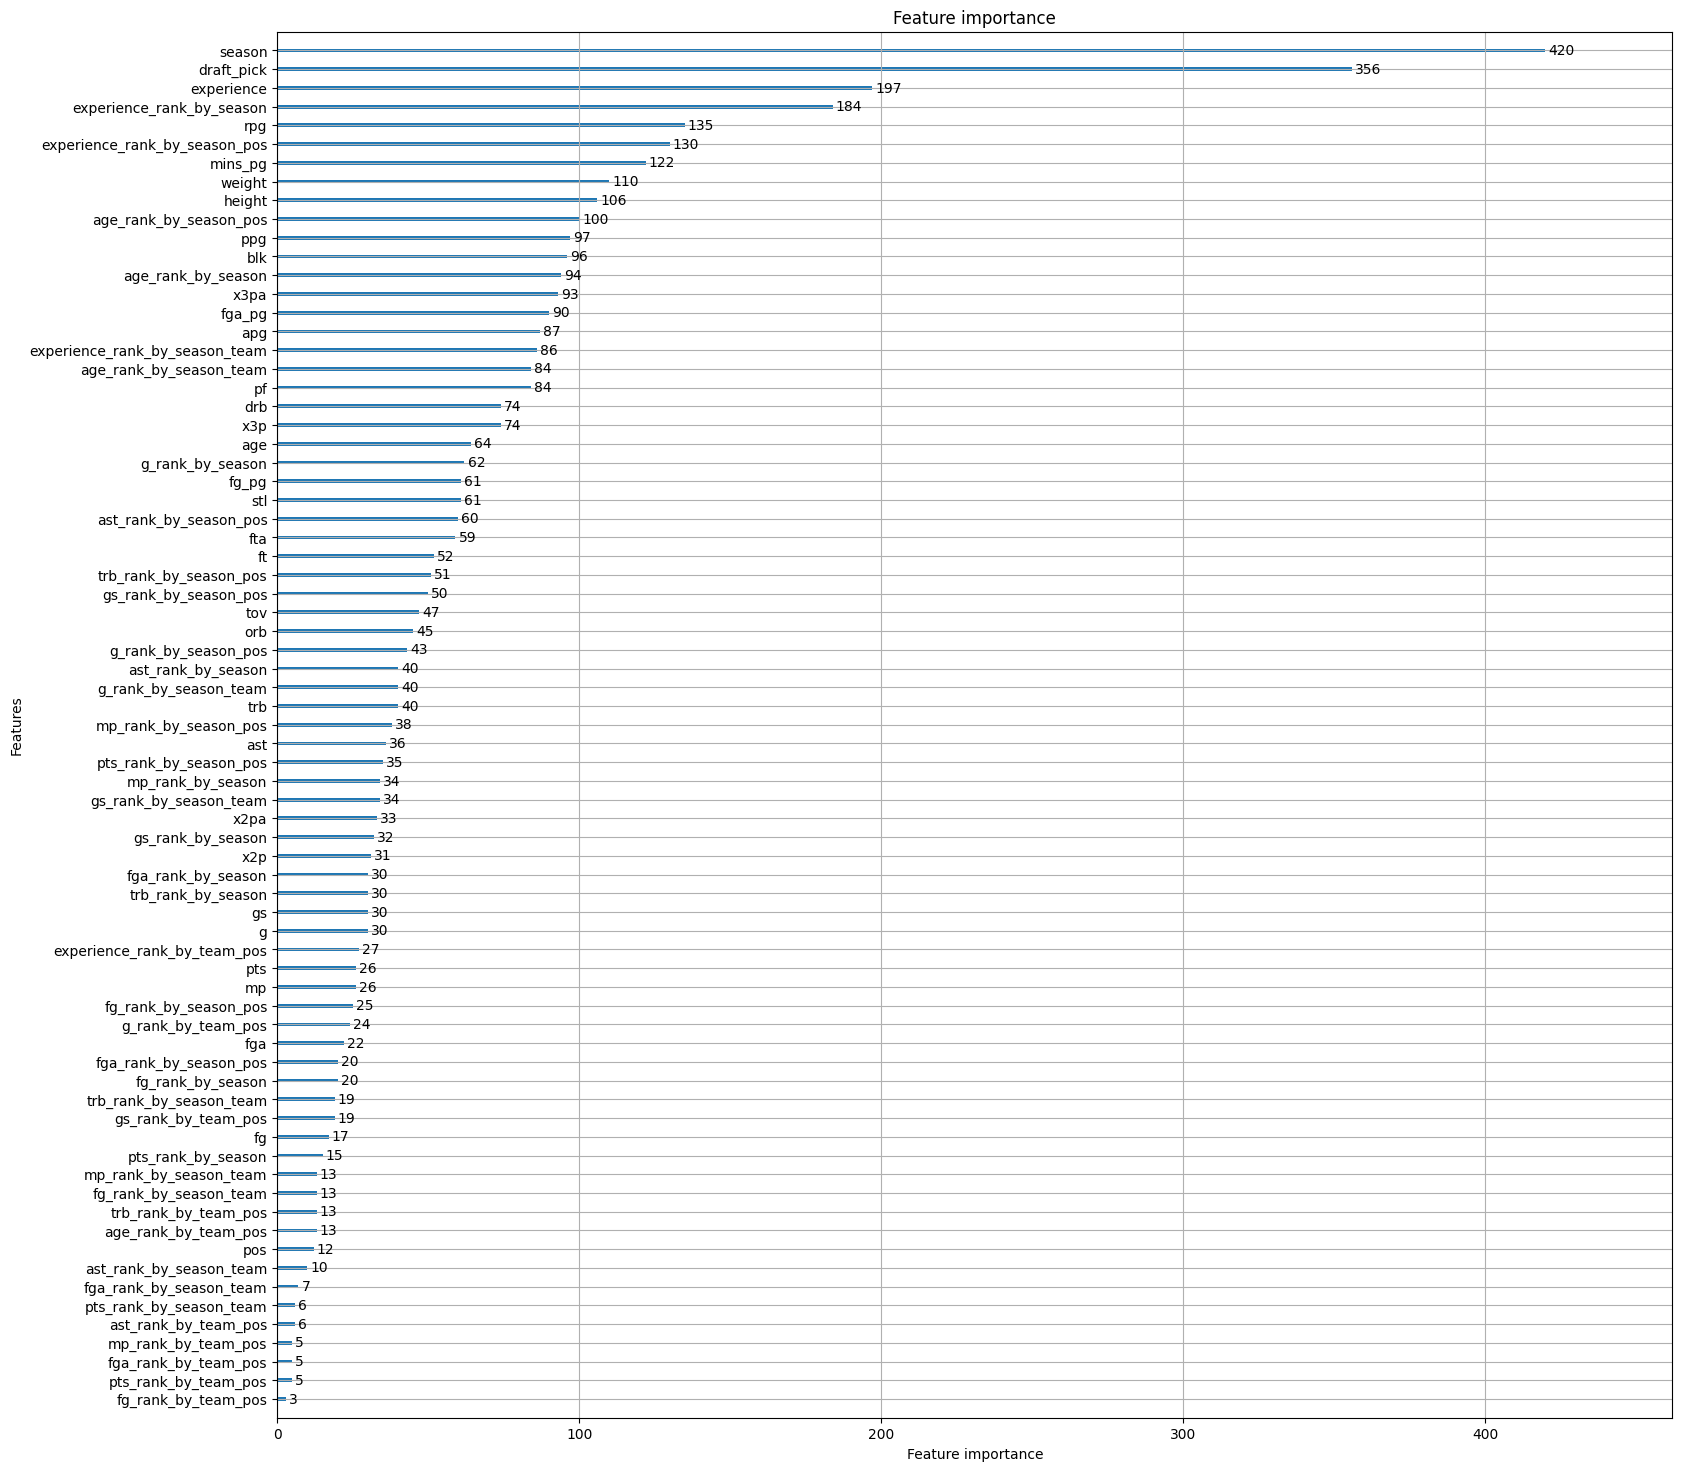

In [66]:
plot_importance(lgb, figsize=(18, 18))

In [67]:
from sklearn.kernel_ridge import KernelRidge

encoded_pos = pd.concat([mdl_df, pd.get_dummies(cleaned_salaries['pos'])], axis=1).drop(columns=['player', 'pos'])

X_train = encoded_pos.loc[train_indices].drop(columns=['adjusted_salary'])
X_test = encoded_pos.loc[test_indices].drop(columns=['adjusted_salary'])

kernel_ridge = KernelRidge(kernel='rbf', alpha=1)
kernel_ridge.fit(X_train, y_train)
train_preds = kernel_ridge.predict(X_train)
test_preds = kernel_ridge.predict(X_test)

val_scores = cross_val_score(kernel_ridge, X_train, y_train, scoring=mse_scorer, cv=5)

print(f'train rmse: {rmse(y_train, train_preds) / 10**6}')
print(f'test rmse: {rmse(y_test, test_preds) / 10**6}')
print(f'cross validation rmse: {abs(val_scores.mean()) / 10**6}')

train rmse: 1.2765957040472602
test rmse: 2.569168341445432
cross validation rmse: 2.549276428559451


In [68]:
mdl_df

,season,draft_pick,height,weight,player,pos,age,experience,g,gs,...,fg_rank_by_season_pos,fg_rank_by_team_pos,fga_rank_by_season,fga_rank_by_season_team,fga_rank_by_season_pos,fga_rank_by_team_pos,mp_rank_by_season,mp_rank_by_season_team,mp_rank_by_season_pos,mp_rank_by_team_pos
0,1990,25,82,240,Alaa Abdelnaby,PF,22.0,1,43.0,0.0,...,63.0,4.0,296.5,12.0,63.0,4.0,307.0,12.0,68.0,4.0
1,1991,25,82,240,Alaa Abdelnaby,PF,23.0,2,71.0,1.0,...,45.0,2.0,209.0,9.0,47.0,2.0,231.0,9.0,53.0,2.0
2,1992,25,82,240,Alaa Abdelnaby,PF,24.0,3,75.0,52.0,...,38.0,3.0,175.0,8.0,41.0,3.0,197.0,8.0,51.0,3.0
3,1993,25,82,240,Alaa Abdelnaby,PF,25.0,4,13.0,0.0,...,74.5,4.0,329.5,12.0,75.5,4.0,334.0,12.0,76.0,4.0
4,1994,25,82,240,Alaa Abdelnaby,PF,26.0,5,54.0,0.0,...,51.0,3.0,256.0,10.0,53.5,3.0,301.0,11.0,69.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,2016,41,84,240,Stephen Zimmerman,C,20.0,1,19.0,0.0,...,75.5,2.0,409.5,11.0,72.5,2.0,415.0,11.0,75.0,2.0
12807,2016,48,80,215,Paul Zipser,SF,22.0,1,44.0,18.0,...,60.0,2.0,310.0,12.0,60.0,2.0,299.0,11.0,58.0,2.0
12808,2017,48,80,215,Paul Zipser,SF,23.0,2,54.0,12.0,...,54.0,1.0,294.0,14.5,45.5,1.0,291.0,13.0,43.0,1.0
12809,2016,32,85,240,Ivica Zubac,C,19.0,1,38.0,11.0,...,53.0,3.0,303.0,11.0,52.0,3.0,328.0,11.0,60.0,3.0


In [69]:
cleaned_salaries[cleaned_salaries['season'] == 1997].adjusted_salary.quantile(0.98) / 10**6

6.539998741433032

In [70]:
cleaned_salaries.adjusted_salary.describe()

count    1.278200e+04
mean     1.617771e+06
std      1.980570e+06
min      1.712485e+03
25%      3.745881e+05
50%      8.547011e+05
75%      2.035419e+06
max      2.064798e+07
Name: adjusted_salary, dtype: float64